In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load libraries and sample data

In [13]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


ticker_list = [
    "SPY",
    "GLD", 
    "TLT",
]
price_data = {}
for ticker in ticker_list:
    # Load sample data
    df = pd.read_pickle(f'data/raw/price/{ticker}_20250202.pkl')
    df.set_index('Date', inplace=True)
    # data.index = pd.to_datetime(data.index, format="mixed")
    price_data[ticker] = df

# Trend following strategy

We attempt to build trend following strategy using the moving average crossover strategy.

# Single asset trend following

We test the trend following strategy performance on a single asset.

Backtesting SMA strategy for SPY
Trend following Results: {'cagr': 0.10259142901499341, 'volatility': 0.13779517261007976, 'sharpe': 0.7445212126936935, 'max_drawdown': 0.33707004700139487, 'cumulative_returns': 19.606840877673008}


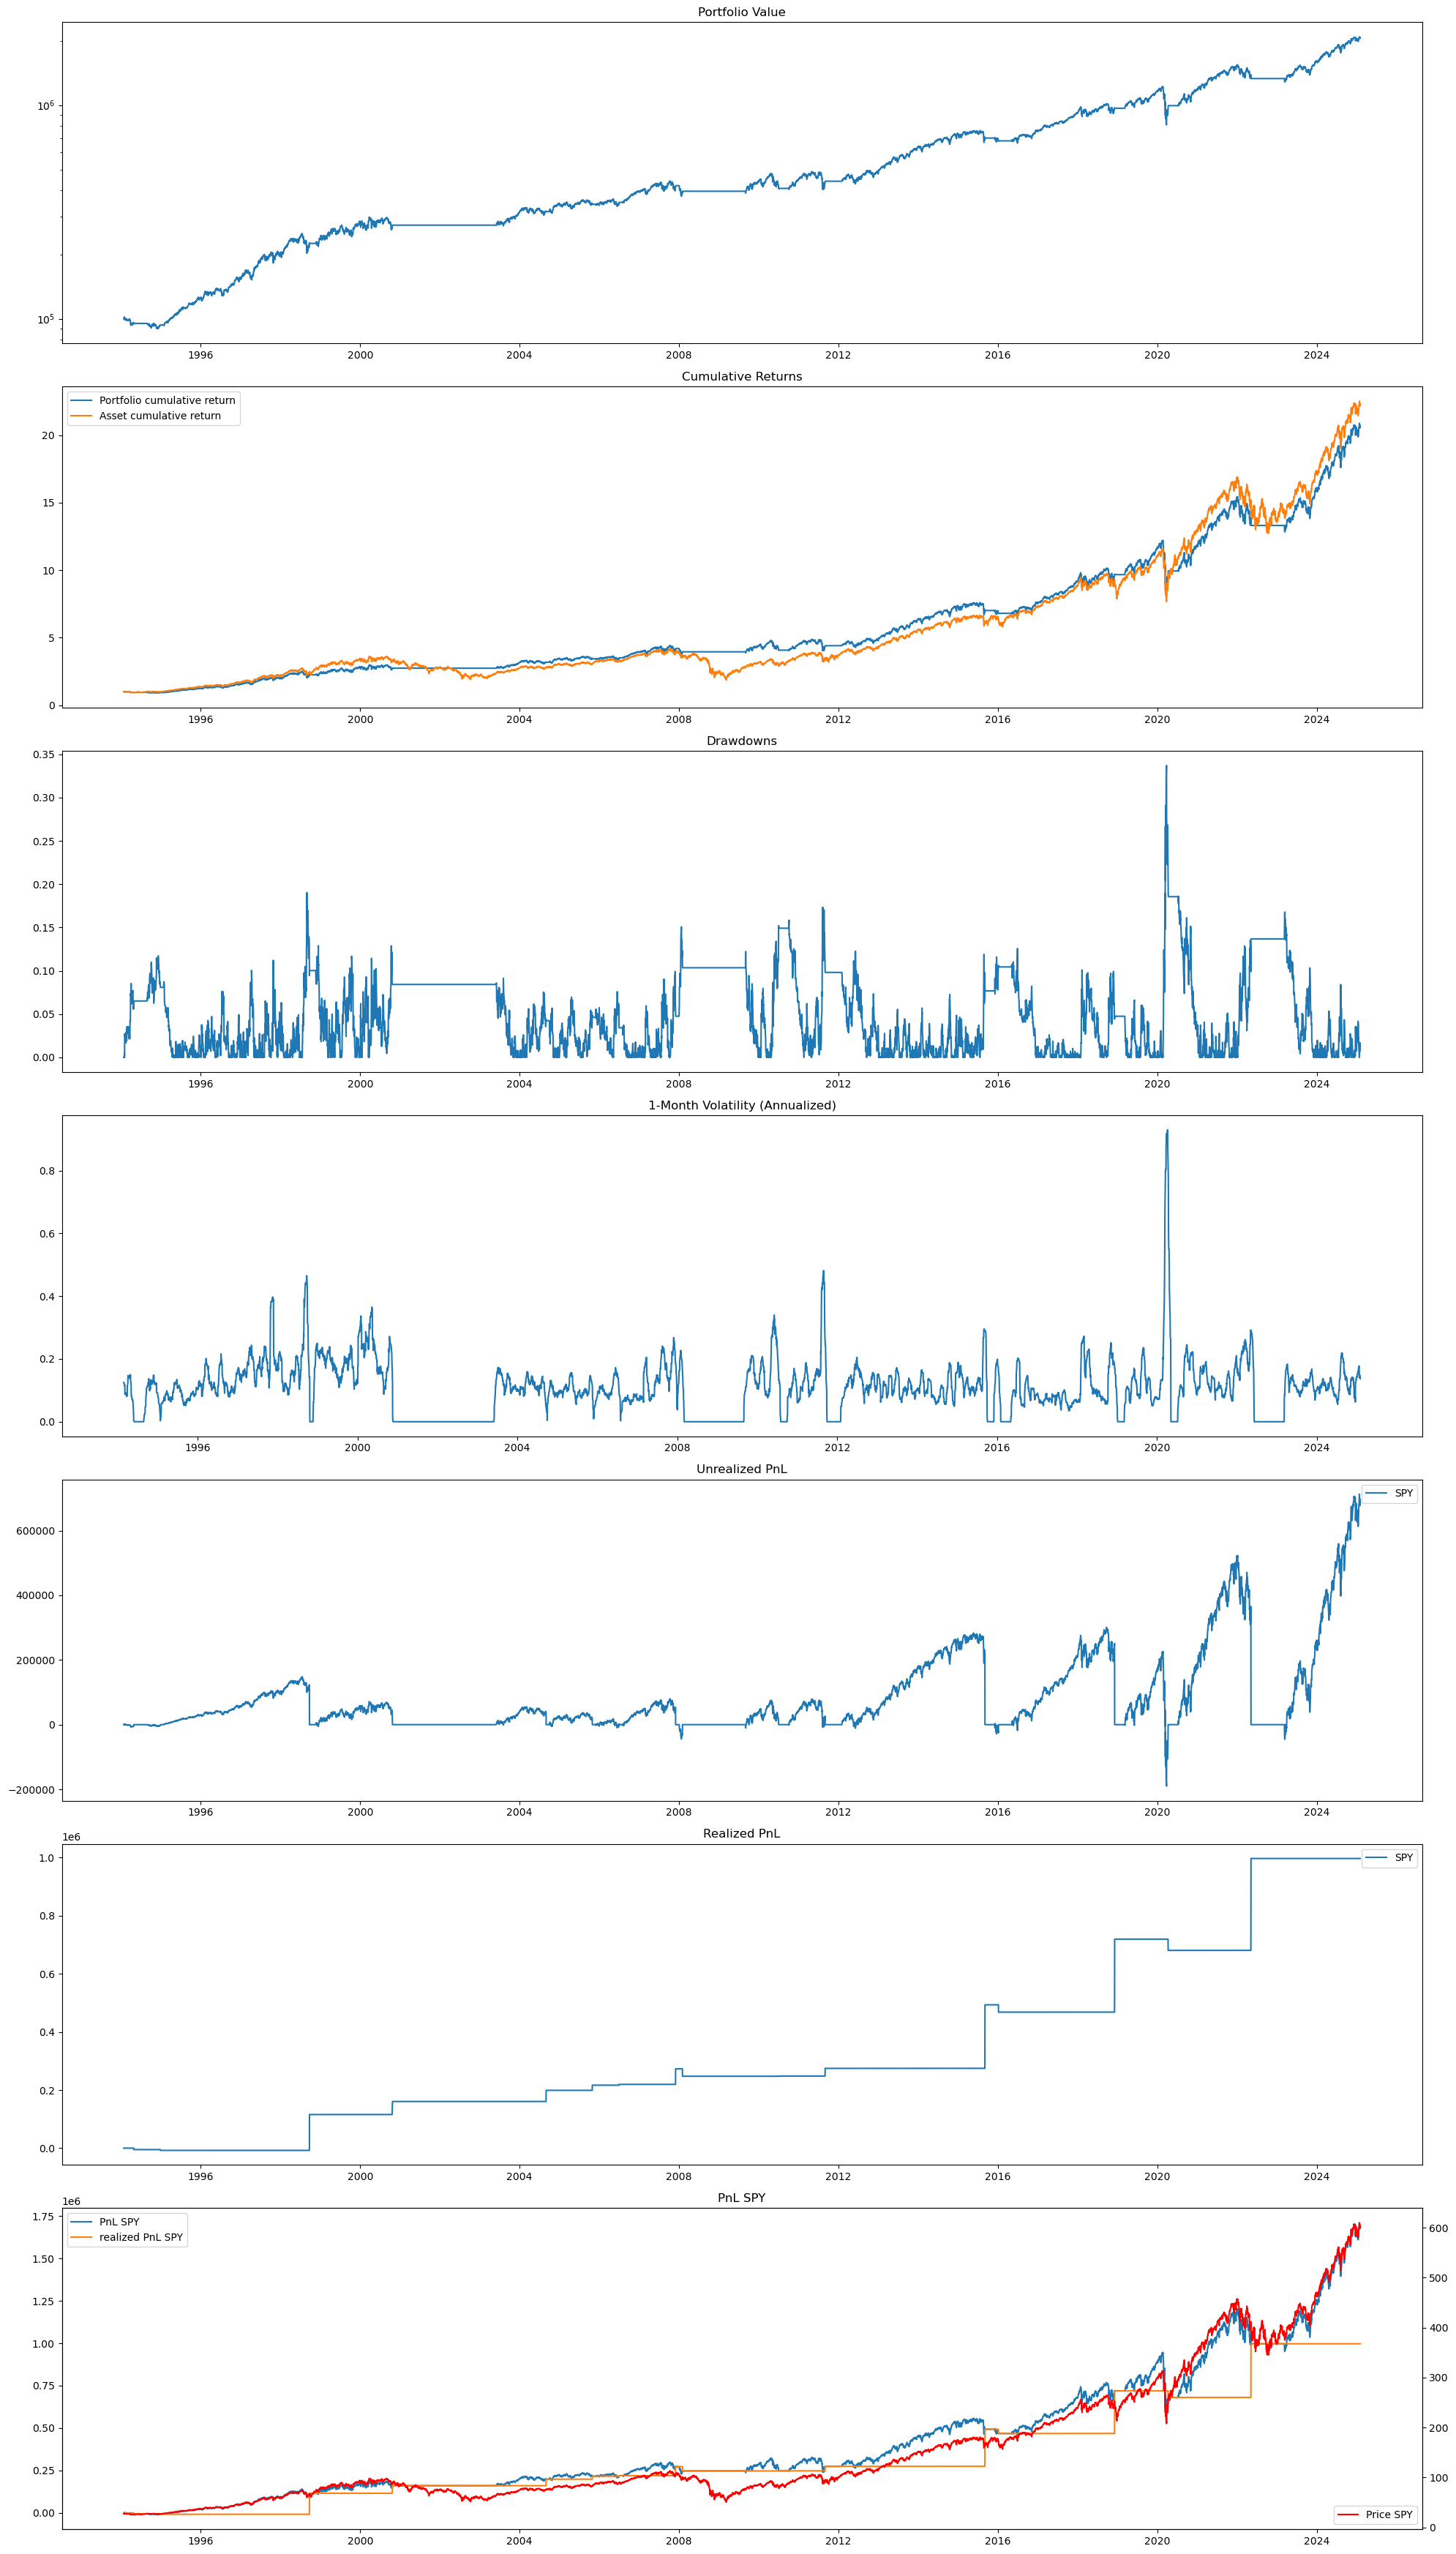

Backtesting SMA strategy for GLD
Trend following Results: {'cagr': 0.07836938261129056, 'volatility': 0.145220231103128, 'sharpe': 0.5396588479165594, 'max_drawdown': 0.3423192080802749, 'cumulative_returns': 3.249176238398266}


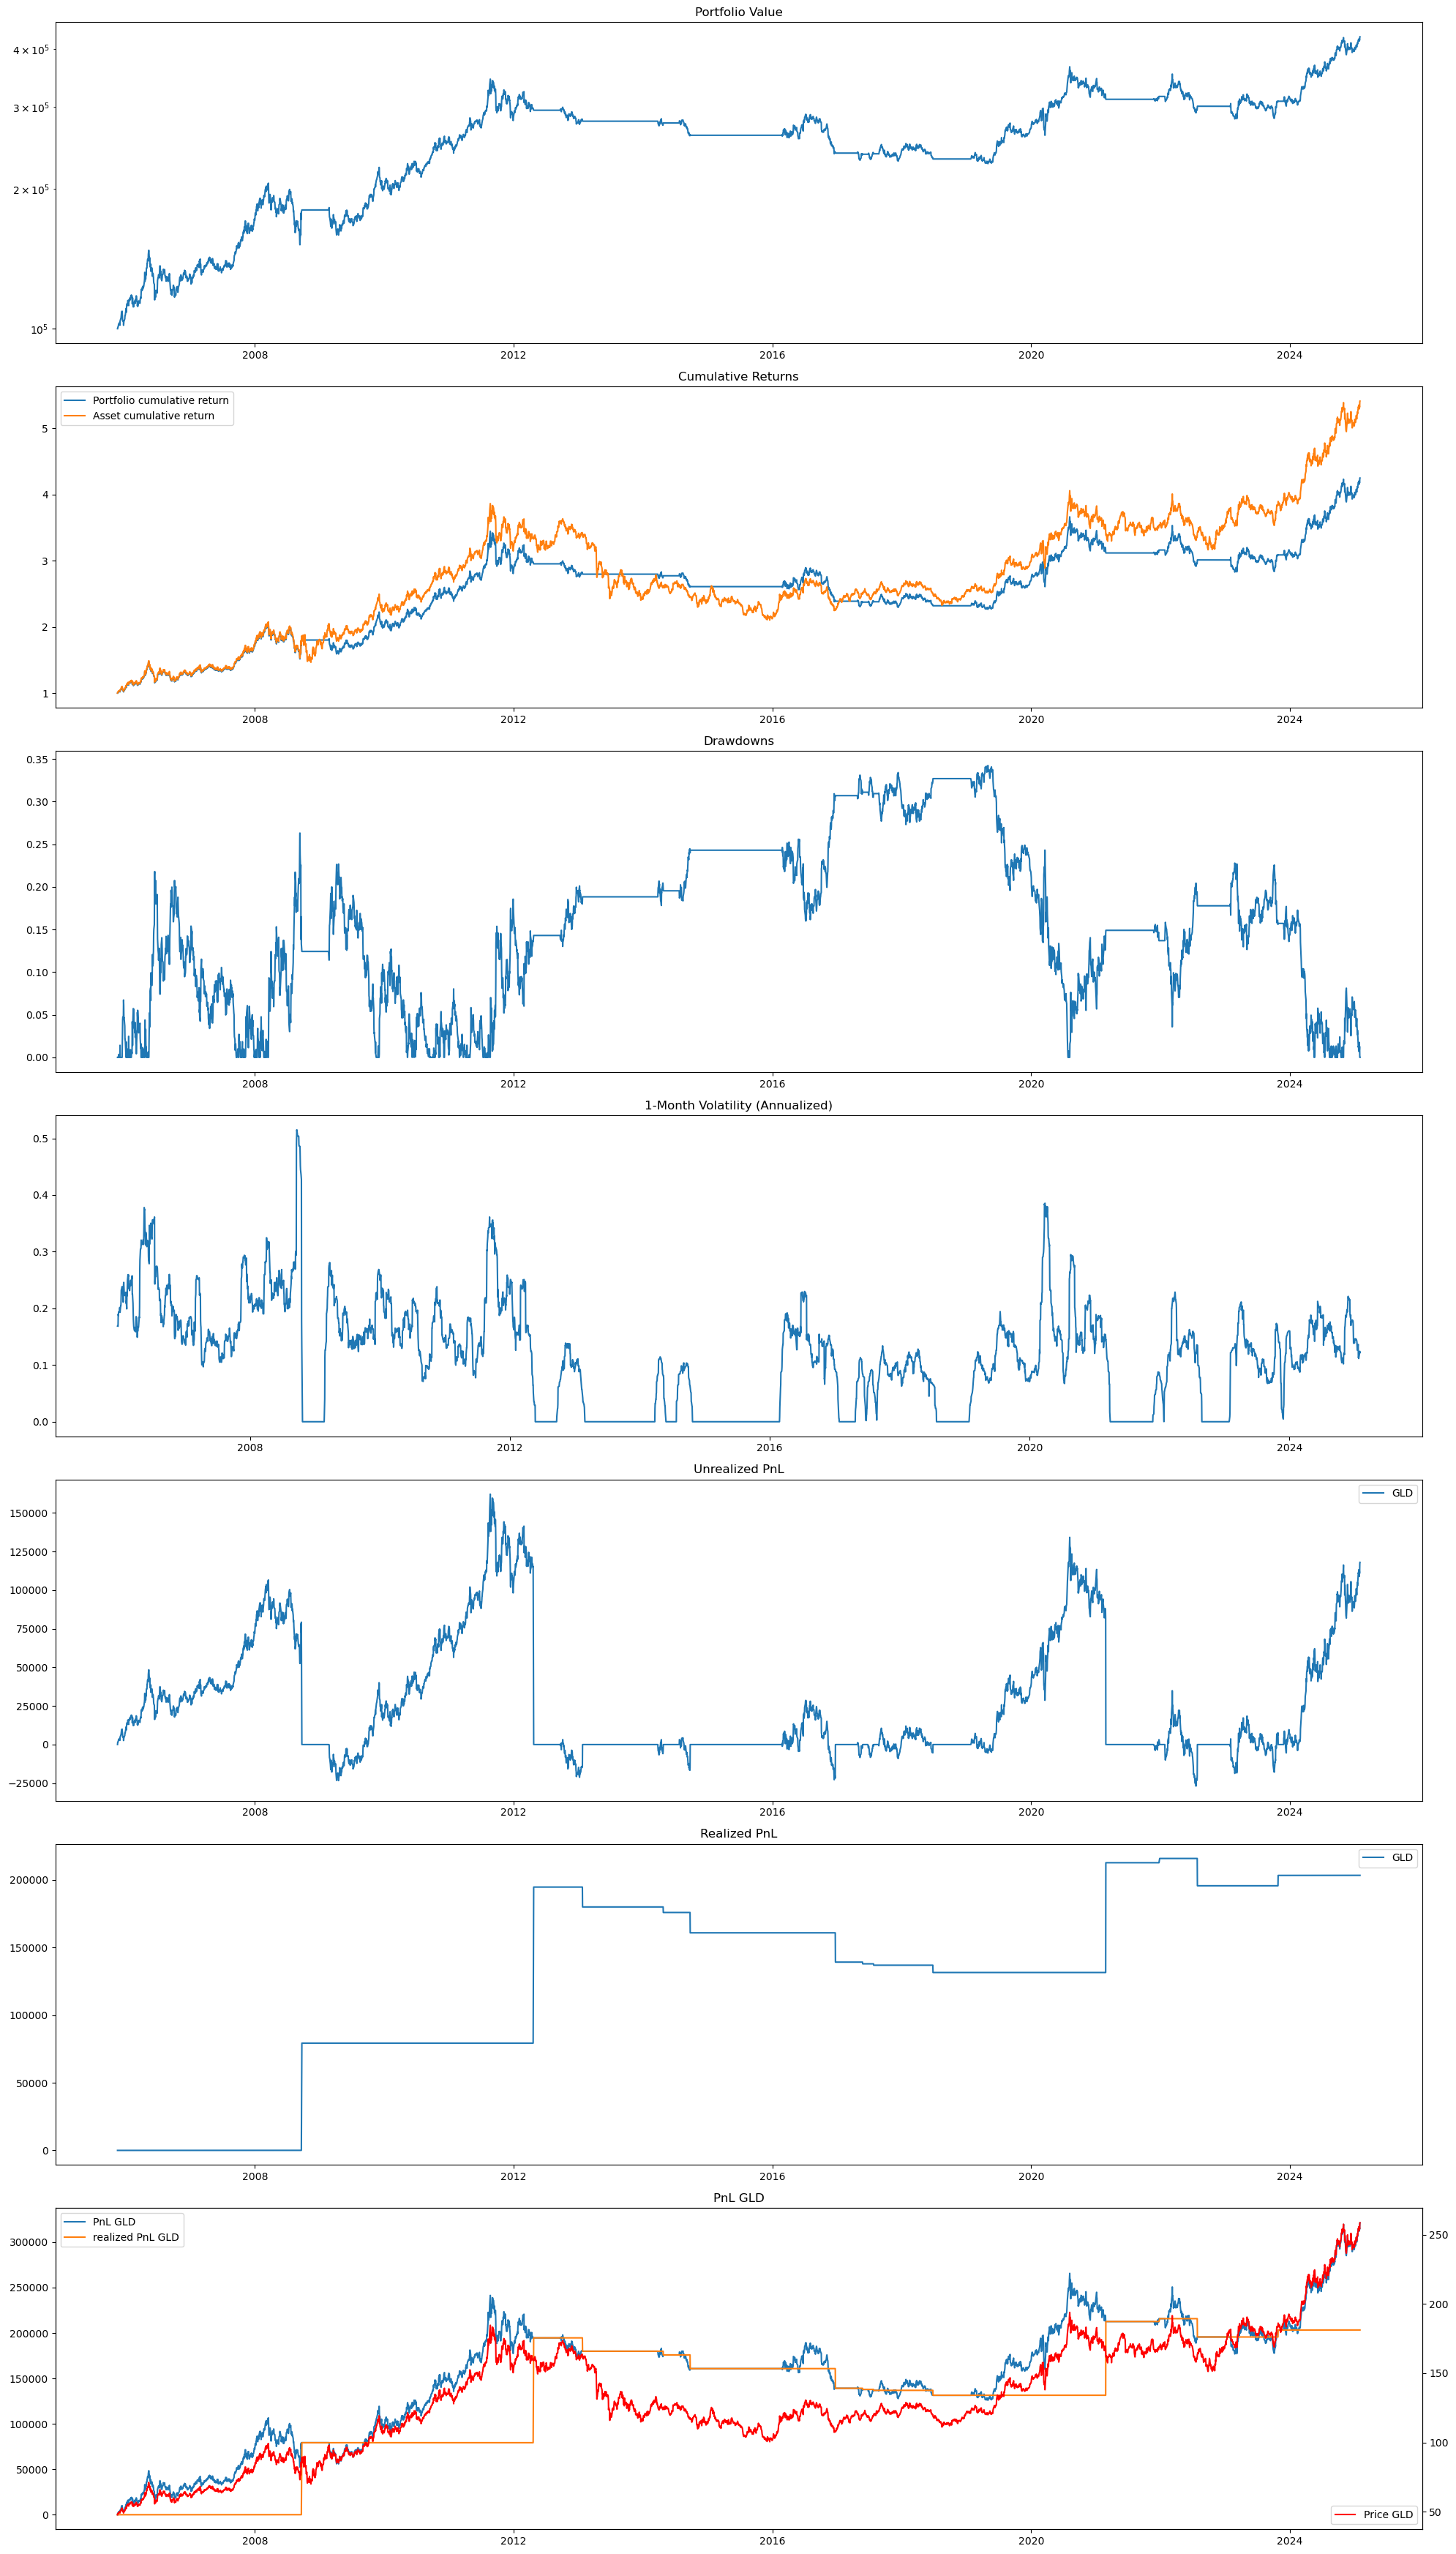

Backtesting SMA strategy for TLT
Trend following Results: {'cagr': 0.020341483842281072, 'volatility': 0.10556675623593413, 'sharpe': 0.1926883478054333, 'max_drawdown': 0.269875494095449, 'cumulative_returns': 0.5413113581637365}


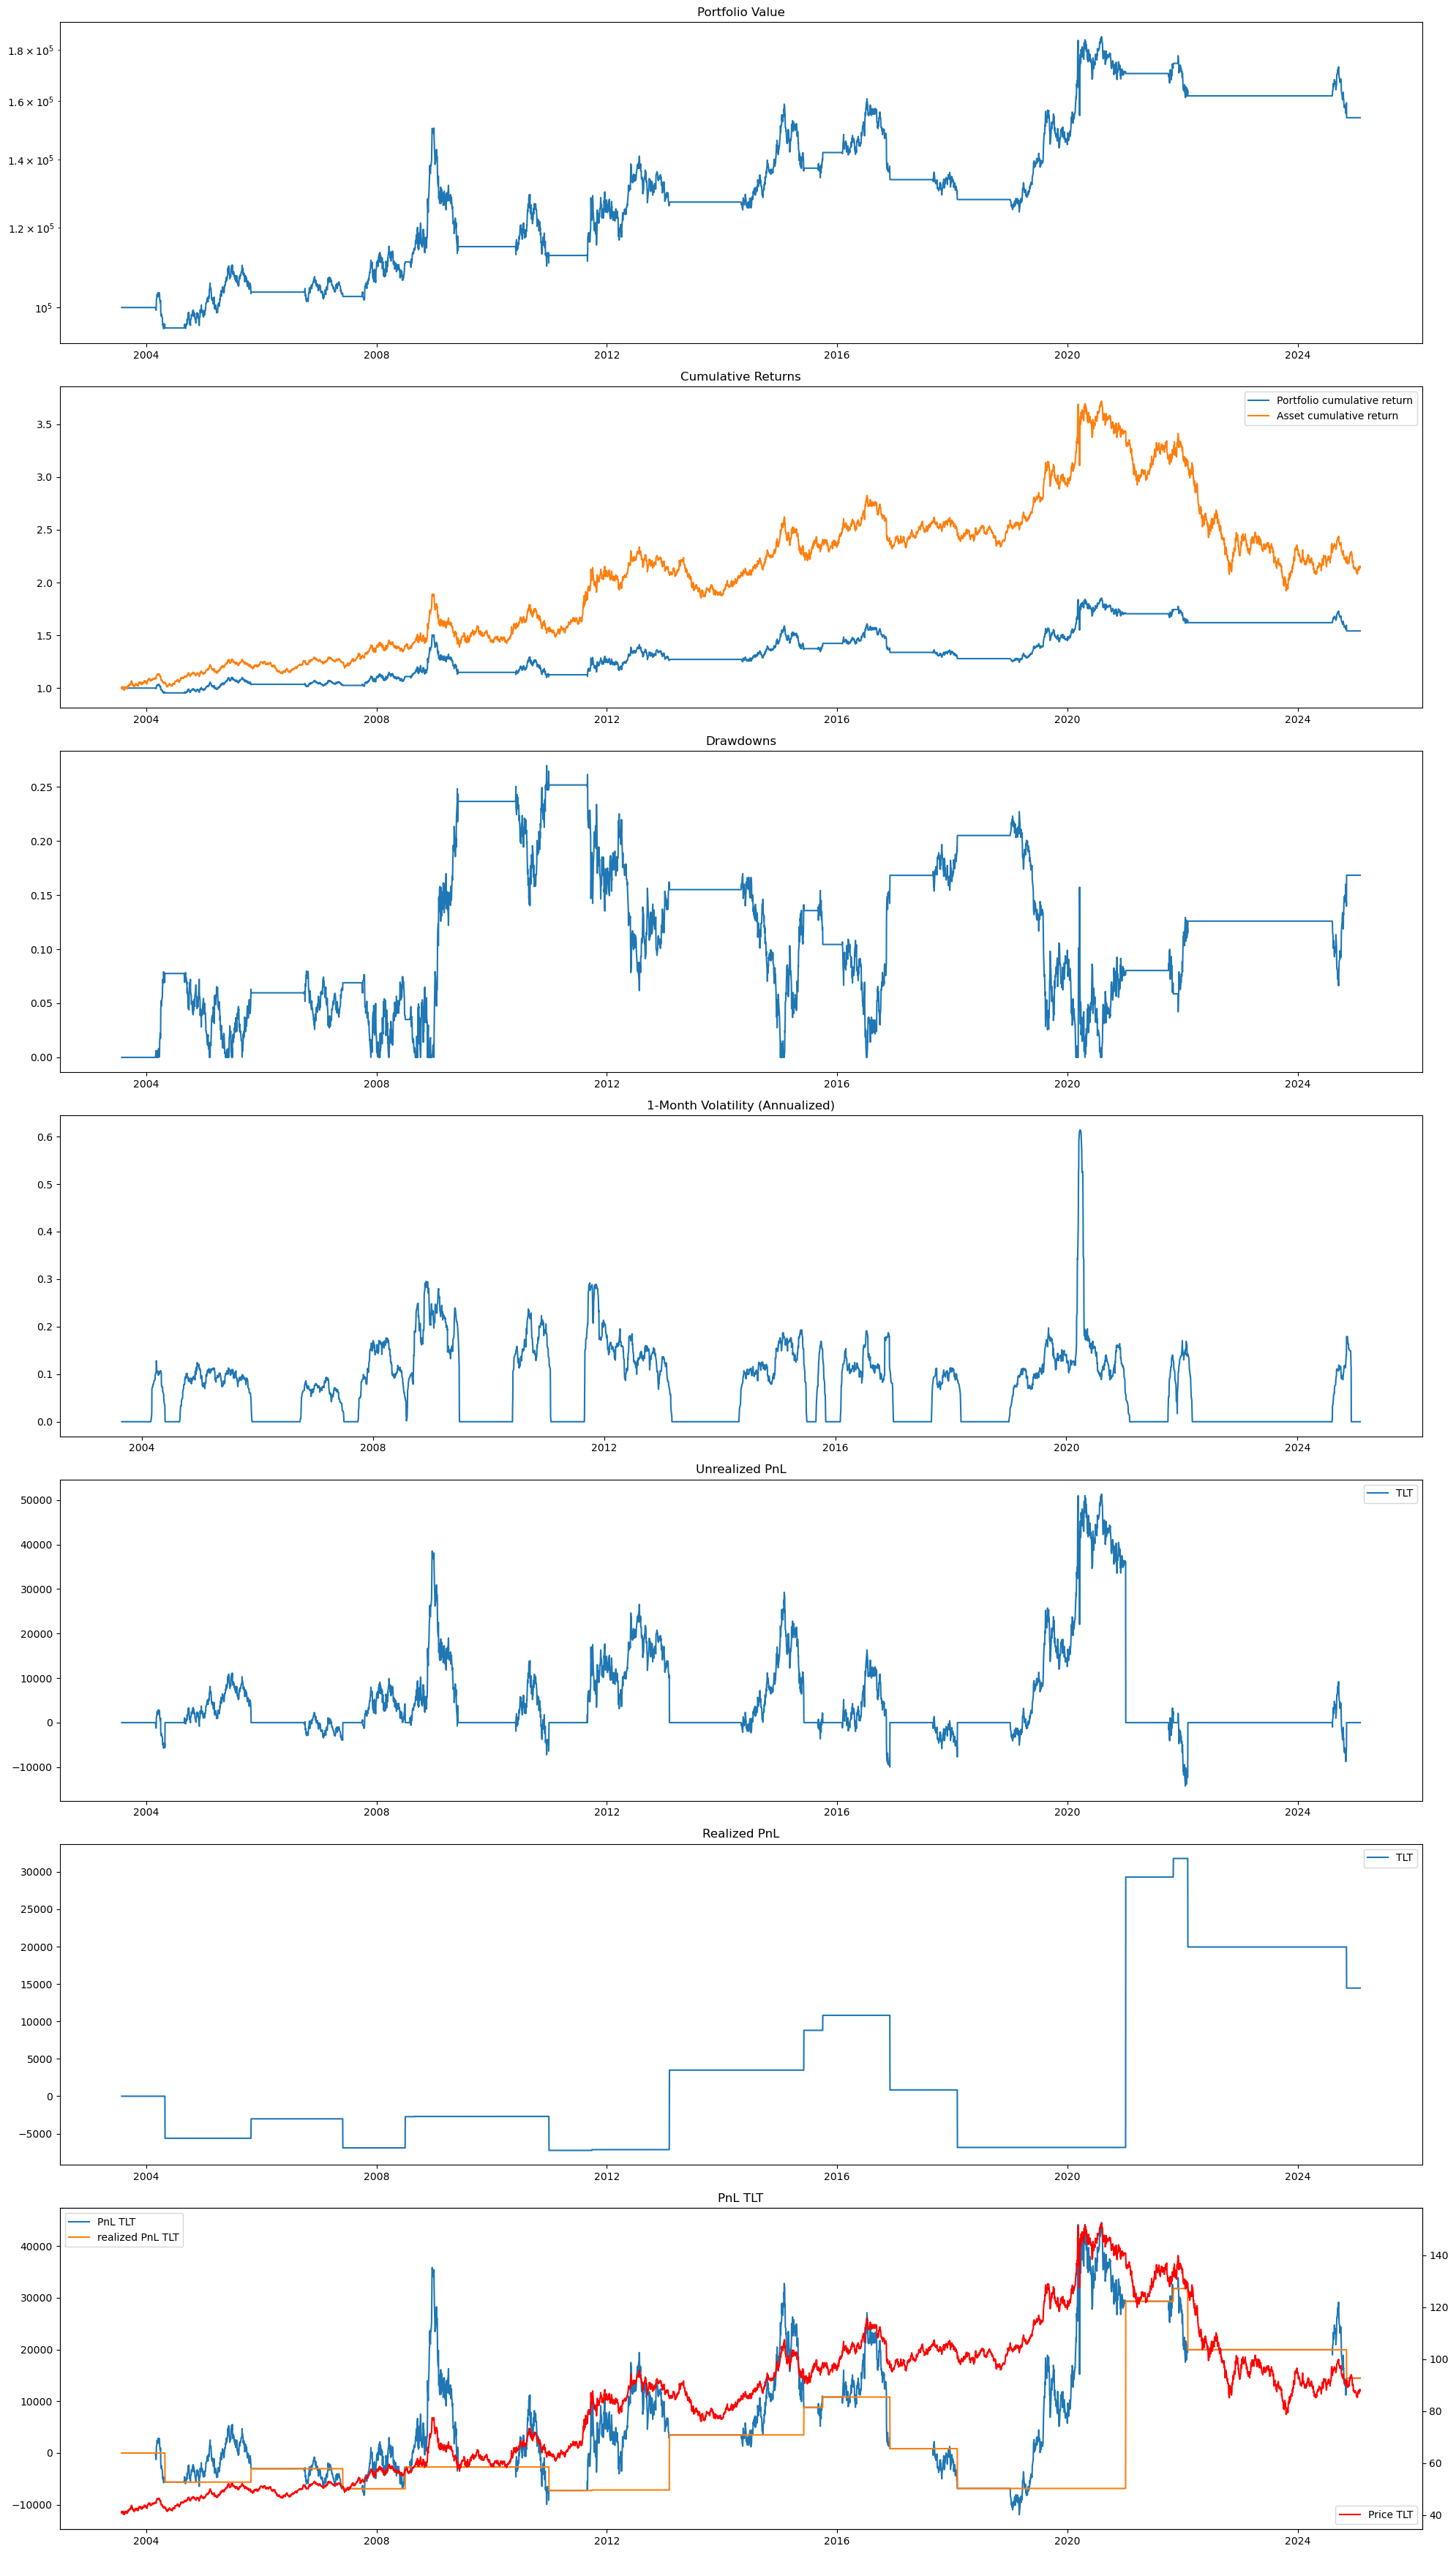

In [14]:
from strategies.trend_following import MovingAverageCrossoverStrategy
from utils.backtester import BackTester


def backtest_sma(ticker, short_window, long_window, rebalance_period):
    print("Backtesting SMA strategy for {}".format(ticker))
    tl = [ticker]
    pda = {ticker: price_data[ticker]}

    bt = BackTester(pda)
    bt.add_strategy(MovingAverageCrossoverStrategy, tickers=tl, price_data=pda, short_window=short_window, long_window=long_window, rebalance_period=rebalance_period)
    results = bt.backtest()
    print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
    bt.plot_results()
    return results['returns']

SMA_returns = {}
for ticker in ticker_list:
    if ticker == 'SHV': continue
    SMA_returns[ticker] = backtest_sma(ticker, 21, 252, 21).to_frame(name='returns')

# Multi asset trend following portfolio

Now we want to combine the assets together into a single portfolio.

## Equal Weighted Portfolio

Trend following Results: {'cagr': 0.06802523447465503, 'volatility': 0.07458106606667066, 'sharpe': 0.9120979098615305, 'max_drawdown': 0.14334439973157428, 'cumulative_returns': 2.532150409474477}


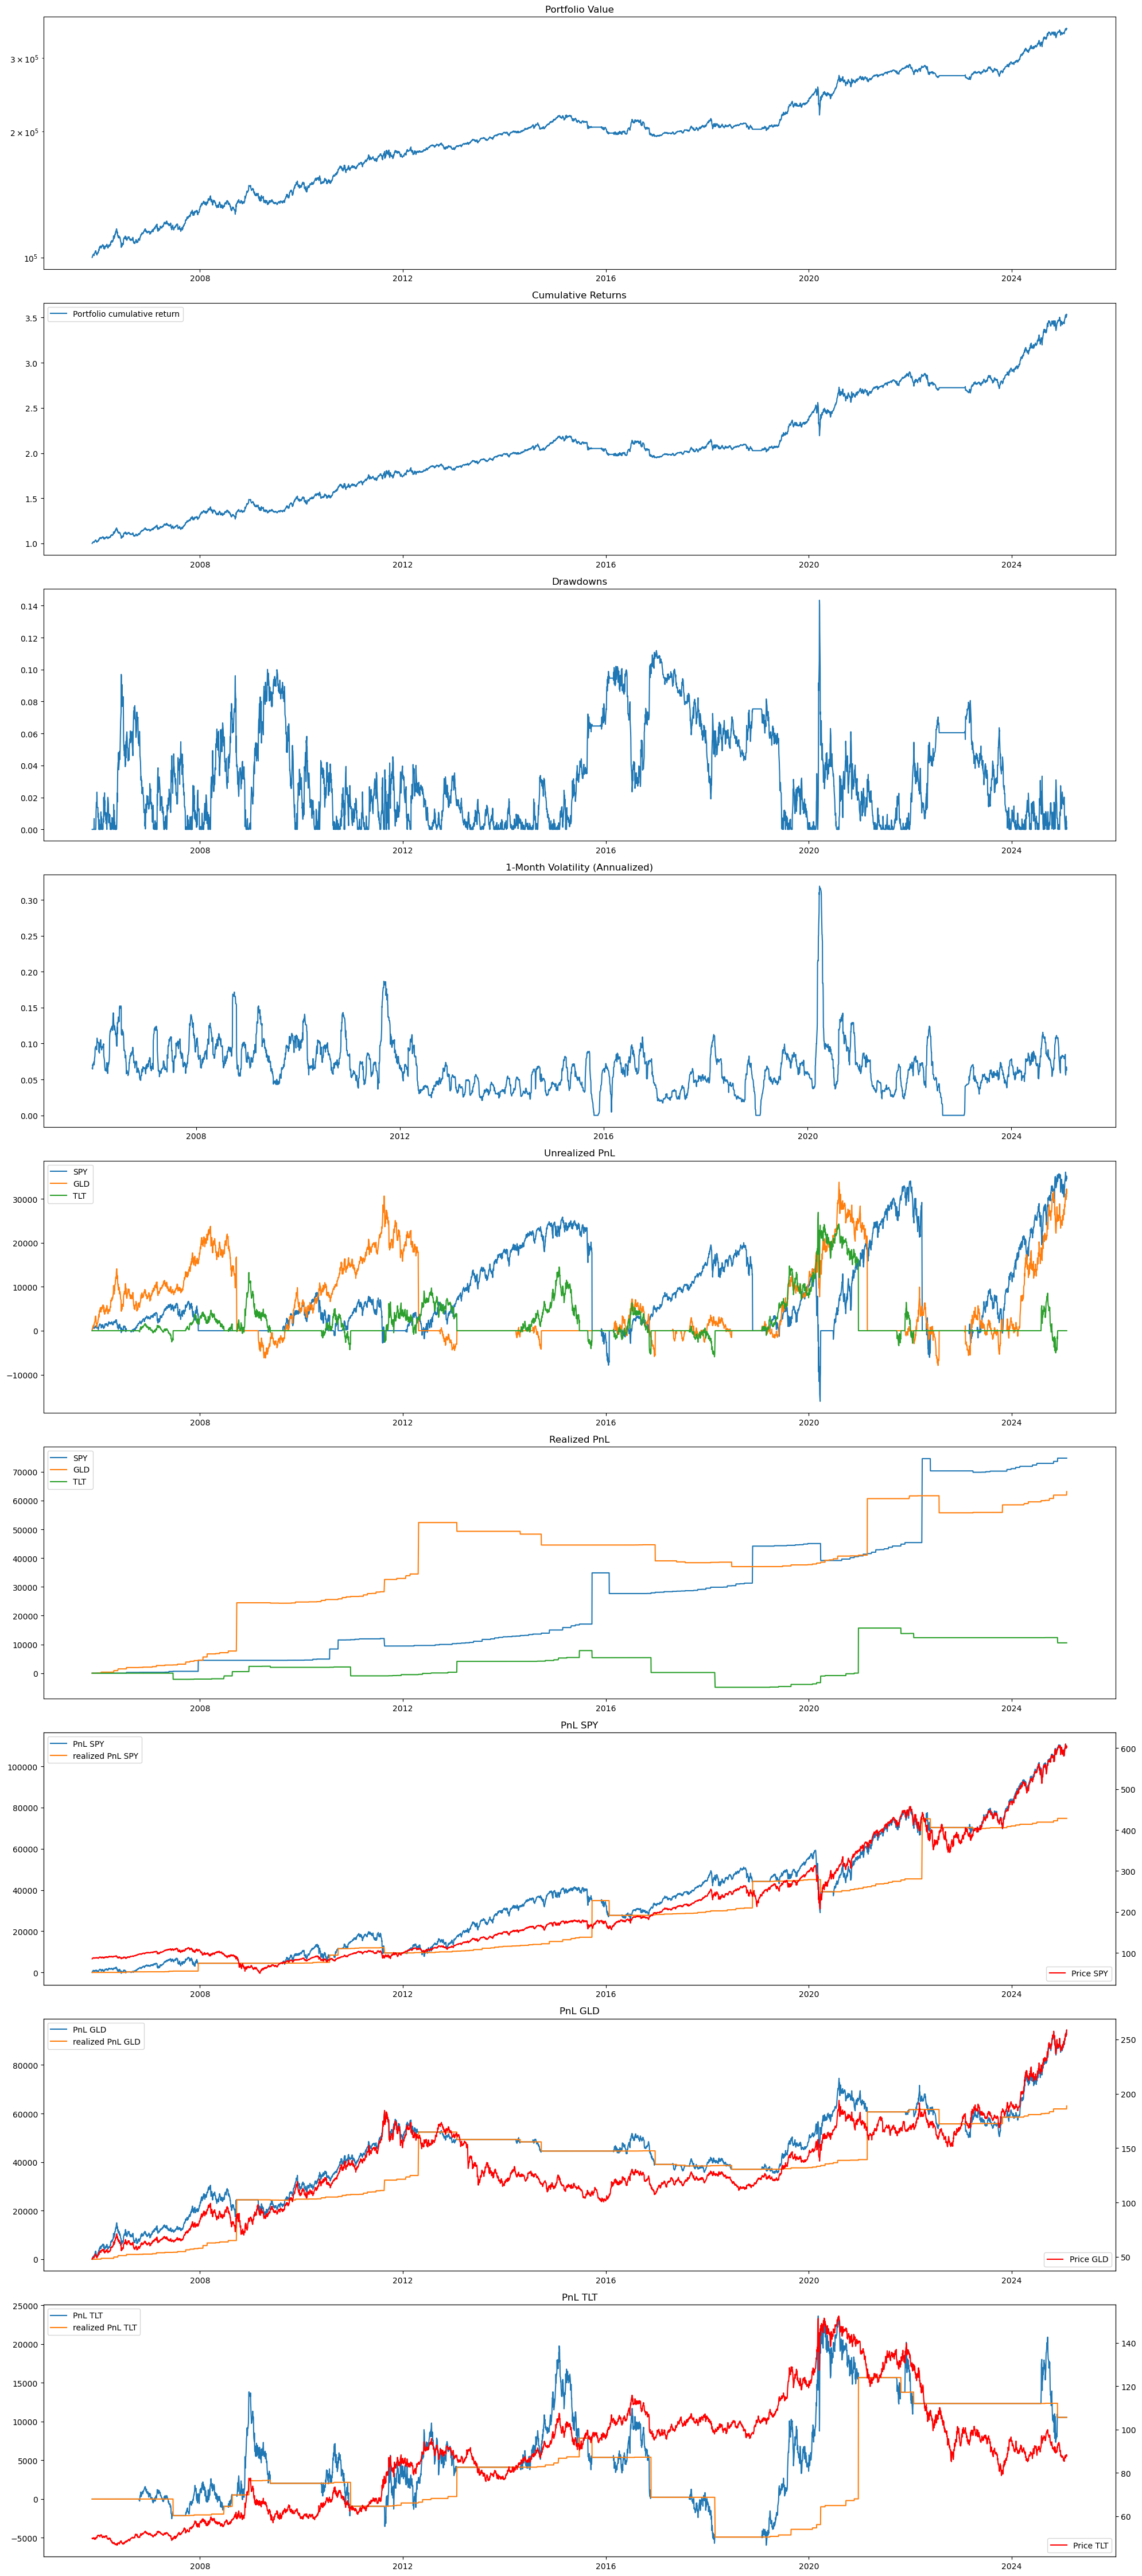

In [15]:
from strategies.trend_following import MultiAssetMovingAverageCrossoverStrategy


bt = BackTester(price_data)
bt.add_strategy(
    MultiAssetMovingAverageCrossoverStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    ticker_list=ticker_list, 
    short_window=21, 
    long_window=252, 
    rebalance_period=21, 
    weights={ticker: 1 for ticker in ticker_list}
)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

## Hierarchical Risk Parity

HRP weights OrderedDict([('GLD', 0.24975071792585918), ('SPY', 0.30516324677669104), ('TLT', 0.4450860352974498)])
Trend following Results: {'cagr': 0.06120441984052993, 'volatility': 0.07058925744312151, 'sharpe': 0.8670500591374889, 'max_drawdown': 0.14396247858452535, 'cumulative_returns': 2.1238239359998383}


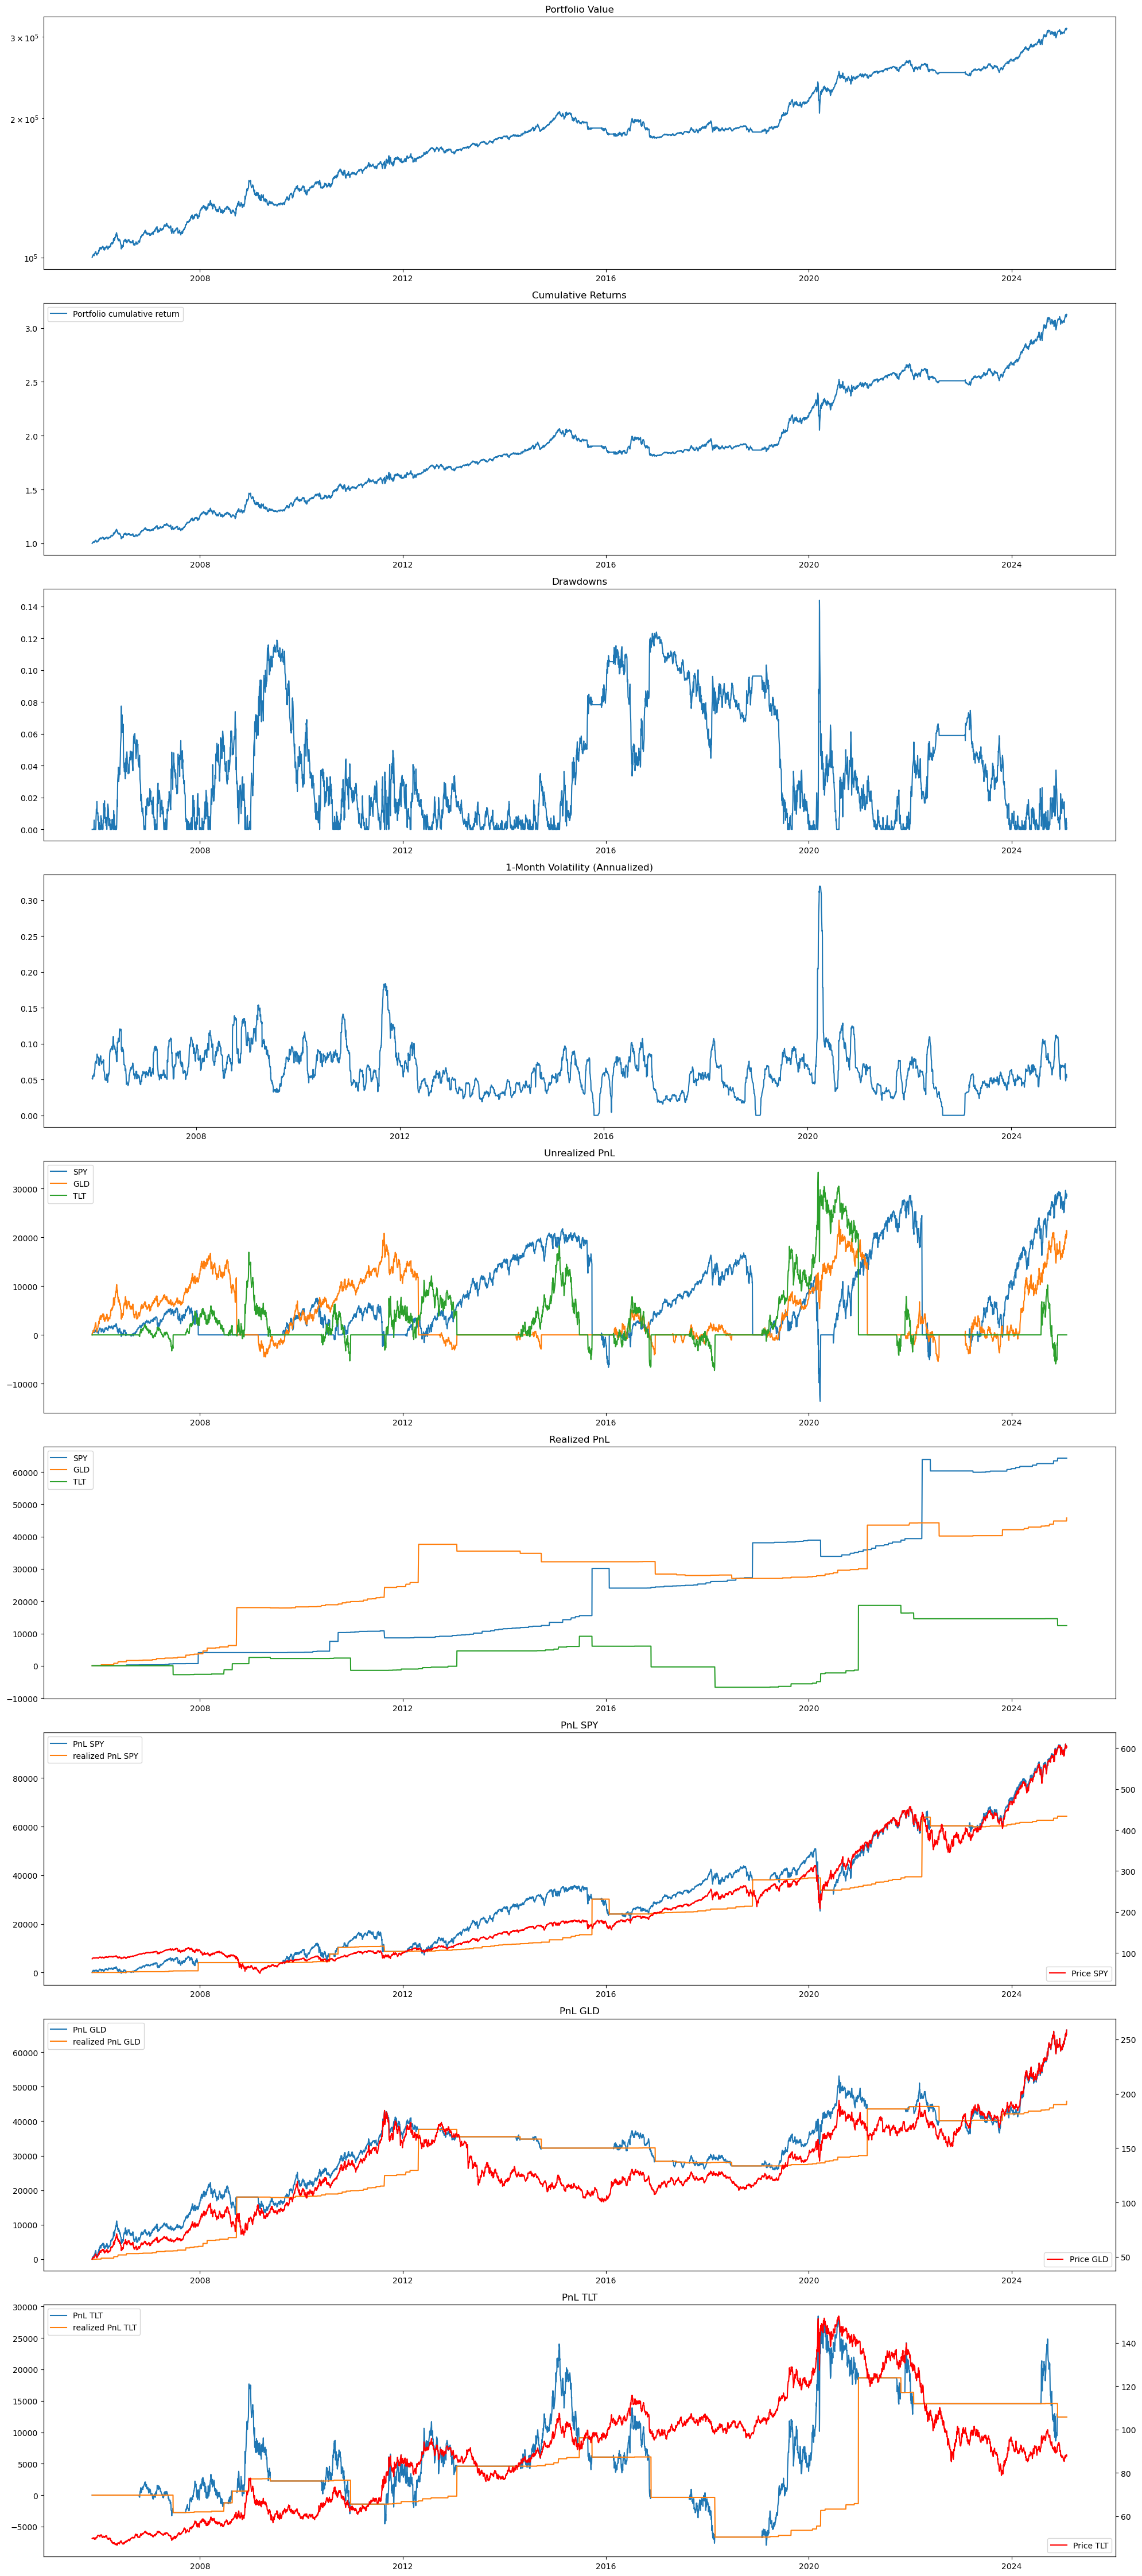

In [16]:
from pypfopt import HRPOpt

def hierarchical_risk_parity_allocation(asset_dfs):
    """
    Perform Hierarchical Risk Parity (HRP) asset allocation given multiple dataframes of asset returns.

    Parameters:
    asset_dfs (list of pd.DataFrame): List of dataframes, each containing 'dates' and 'returns' columns.

    Returns:
    dict: Asset allocation weights with generated asset names as keys.
    """
    processed_series = []
    
    # Process each asset dataframe to create return series with unique names
    for ticker in asset_dfs:
        df = asset_dfs[ticker].copy()
        df = df[~df.index.duplicated(keep='first')]  # Remove duplicate dates
        processed_series.append(df['returns'].rename(ticker))
    
    # Combine all series into a single dataframe with inner join
    combined_df = pd.concat(processed_series, axis=1, join='inner')
    
    if combined_df.empty:
        raise ValueError("No common dates found across all assets")
    
    # Calculate HRP weights
    hrp = HRPOpt(combined_df)
    hrp_weights = hrp.optimize()
    
    return hrp_weights


hrp_weights = hierarchical_risk_parity_allocation(SMA_returns)
print("HRP weights", hrp_weights)


bt = BackTester(price_data)
bt.add_strategy(
    MultiAssetMovingAverageCrossoverStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    ticker_list=ticker_list, 
    short_window=21, 
    long_window=252, 
    rebalance_period=21, 
    weights=hrp_weights,
)

results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

## Optuna

We can also use optuna to optimize the weights of each asset

In [17]:
import optuna

def objective(trial):
    test_weights = {
        "SPY": trial.suggest_float("SPY", 0, 1),
        "GLD": trial.suggest_float("GLD", 0, 1),
        "TLT": trial.suggest_float("TLT", 0, 1),
    }

    tl = ['SPY', 'GLD', 'TLT']
    pda = {t: price_data[t] for t in tl}
    bt = BackTester(pda)
    bt.add_strategy(MultiAssetMovingAverageCrossoverStrategy, tickers=tl, price_data=pda, ticker_list=tl, short_window=21, long_window=252, rebalance_period=21, weights=test_weights)
    results = bt.backtest()
    return results['sharpe']

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, show_progress_bar=True)
optuna_weights = study.best_params
total_weight = sum(optuna_weights.values())
for ticker in optuna_weights:
    optuna_weights[ticker] /= total_weight

[I 2025-02-09 22:53:31,530] A new study created in memory with name: no-name-4541b8d7-c9c1-43cf-9c50-69cf68423bc4


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-02-09 22:53:39,483] Trial 0 finished with value: 0.7039525175233149 and parameters: {'SPY': 0.25367558429107717, 'GLD': 0.7867023374790717, 'TLT': 0.8978244692086278}. Best is trial 0 with value: 0.7039525175233149.
[I 2025-02-09 22:53:47,828] Trial 1 finished with value: 0.9244847184527967 and parameters: {'SPY': 0.7635002692798087, 'GLD': 0.5221965365202277, 'TLT': 0.7707349619504389}. Best is trial 1 with value: 0.9244847184527967.
[I 2025-02-09 22:53:55,770] Trial 2 finished with value: 0.8776314412997054 and parameters: {'SPY': 0.5198600559010208, 'GLD': 0.7402231873633944, 'TLT': 0.3196013593523891}. Best is trial 1 with value: 0.9244847184527967.
[I 2025-02-09 22:54:03,536] Trial 3 finished with value: 0.6468114565095021 and parameters: {'SPY': 0.15055317051165884, 'GLD': 0.5834586822755493, 'TLT': 0.8049540781598337}. Best is trial 1 with value: 0.9244847184527967.
[I 2025-02-09 22:54:11,720] Trial 4 finished with value: 0.7908117538897942 and parameters: {'SPY': 0.2235

In [19]:
optuna_weights

{'SPY': 0.44862803310310145,
 'GLD': 0.269011989362878,
 'TLT': 0.2823599775340205}

Trend following Results: {'cagr': 0.07206491279394966, 'volatility': 0.07595261157554253, 'sharpe': 0.9488141526545646, 'max_drawdown': 0.15921017386907838, 'cumulative_returns': 2.7973205734710955}


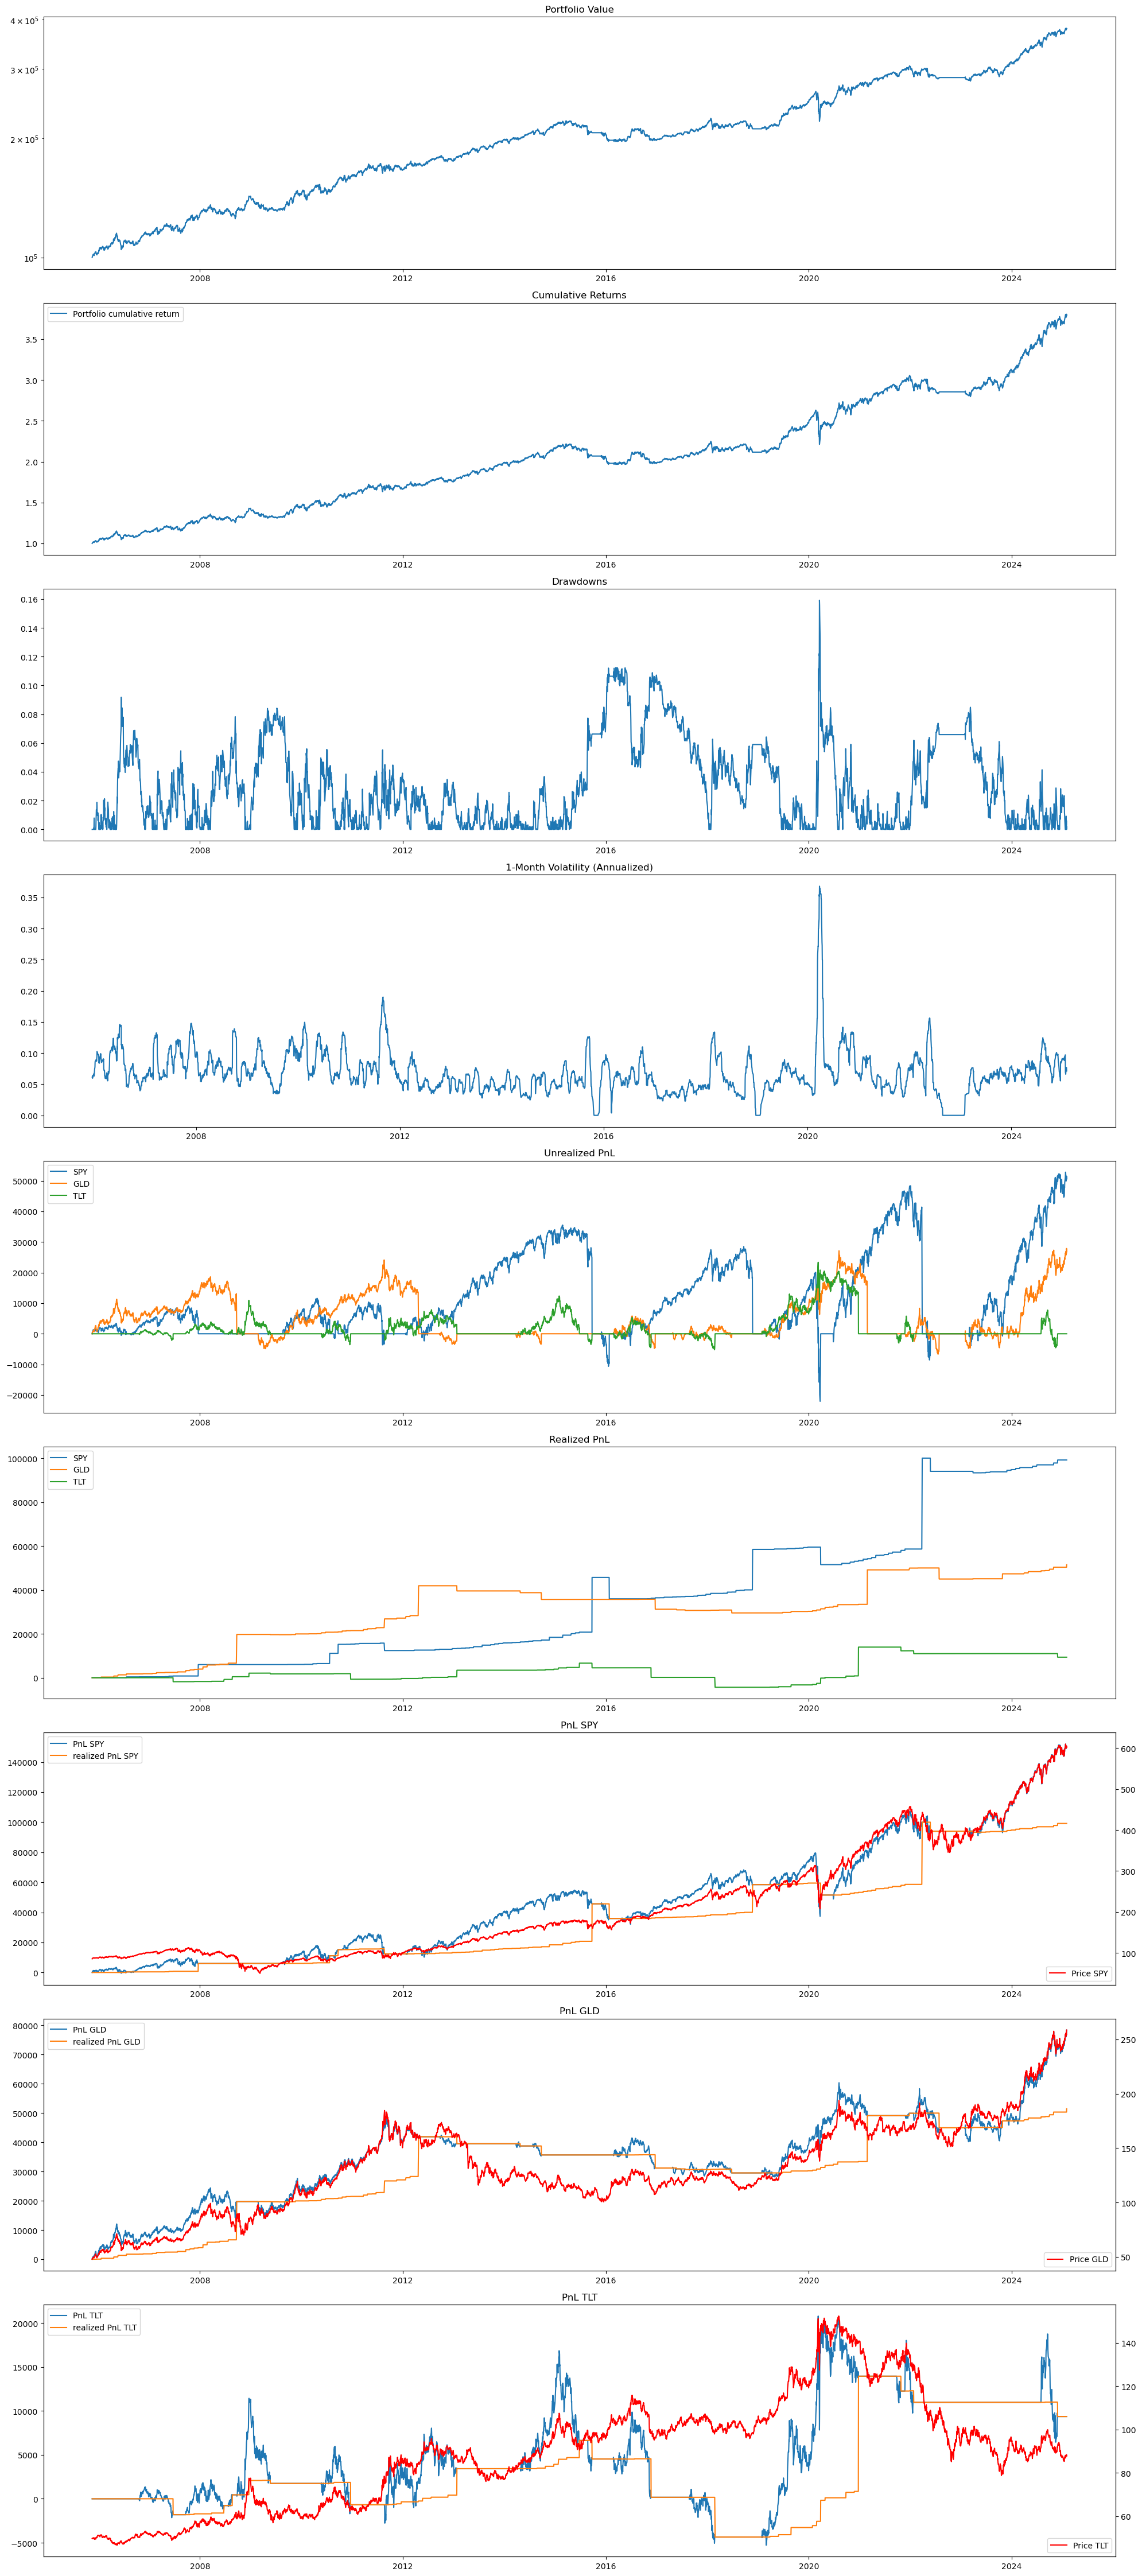

In [18]:
bt = BackTester(price_data)
bt.add_strategy(
    MultiAssetMovingAverageCrossoverStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    ticker_list=ticker_list, 
    short_window=21, 
    long_window=252, 
    rebalance_period=21, 
    weights=optuna_weights,
)

results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

# END